In this notebook, we will try to create the segmenation masks for the images collected in the HOTOSM project. For this we will take a look at the COCO file containing the annotations and masks information of the images. 

In [2]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from pycocotools.coco import COCO
from matplotlib import colors

In [3]:
! ls ../../data/Segmentation

coco   images


In [4]:
# Path to your COCO annotation file
annotation_file = '../../data/Segmentation/coco/full/coco.json'
image_path = '../../data/Segmentation/images/'

# Initialize COCO api
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [5]:
# Loading different categories in the COCO file
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print("COCO Categories:", category_names)

COCO Categories: ['Road Polygon', 'Paved', 'Not Paved', 'Building Polygon', 'Wood', 'Metal (Iron, Steel, etc.)', 'Masonry (Concrete, Brick, etc.)', 'Earthen (Mud, Clay, etc.)', 'Vegetative', 'Road Mask', 'Paved', 'Not Paved', 'Building Mask', 'Wood', 'Metal (Iron, Steel, etc.)', 'Masonry (Concrete, Brick, etc.)', 'Earthen (Mud, Clay, etc.)', 'Vegetative', 'Glass']


In [6]:
# Getting the list of image annotations
img_ids = coco.getImgIds()
print("Total images:", len(img_ids))

Total images: 913


In [7]:
# Getting the information saved for each image annotations
img_info = coco.loadImgs(img_ids[500])[0]
print("Image Info:", img_info)

Image Info: {'license': 1, 'file_name': 'HOTOSM-Street-Level-Dataset-Kenya-narok_blg56.jpg', 'height': 724, 'width': 1326, 'date_captured': '2025-03-16T09:05:11.000+00:00', 'id': 513, 'coco_url': 'https://storage.labelbox.com/cjw0uwr2ui0vm0828opkmr7uf%2F47f90123-91cc-eb01-d093-9d53d1b3567e-narok_blg56.jpg?Expires=1744222392379&KeyName=labelbox-assets-key-3&Signature=MgBsB_tIXeh64jB1BpB9eVggPRM'}


Each image annotation has an 'id' which is basically the filename for which annotations were labelled. 

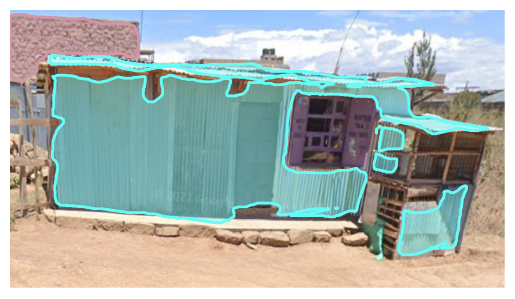

In [9]:
# Load and display image
img = coco.loadImgs(img_ids[365])[0]
image_file = image_path + f"{img['id']}.jpg"
I = skimage.io.imread(image_file)
plt.imshow(I); plt.axis('off')

# Load and display annotations
ann_ids = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(ann_ids)
coco.showAnns(anns)

In [10]:
print(len(anns))
for ann in anns:
    print(ann['category_id'])

2
19
20


In [11]:
print(ann_ids)

['cm8a9lp6u00gb3j6tefx6m4m1', 'cm8a9nuei00gn3j6t9oqa7pc6']


In [12]:
import json

json_file = annotation_file

f = open(json_file)
data = json.load(f)
f.close()

In [13]:
print(data['categories'])

[{'supercategory': 'Road Polygon', 'id': 1, 'name': 'Road Polygon'}, {'supercategory': 'Road Polygon', 'id': 3, 'name': 'Paved'}, {'supercategory': 'Road Polygon', 'id': 4, 'name': 'Not Paved'}, {'supercategory': 'Building Polygon', 'id': 5, 'name': 'Building Polygon'}, {'supercategory': 'Building Polygon', 'id': 7, 'name': 'Wood'}, {'supercategory': 'Building Polygon', 'id': 8, 'name': 'Metal (Iron, Steel, etc.)'}, {'supercategory': 'Building Polygon', 'id': 9, 'name': 'Masonry (Concrete, Brick, etc.)'}, {'supercategory': 'Building Polygon', 'id': 10, 'name': 'Earthen (Mud, Clay, etc.)'}, {'supercategory': 'Building Polygon', 'id': 11, 'name': 'Vegetative'}, {'supercategory': 'Road Mask', 'id': 12, 'name': 'Road Mask'}, {'supercategory': 'Road Mask', 'id': 14, 'name': 'Paved'}, {'supercategory': 'Road Mask', 'id': 15, 'name': 'Not Paved'}, {'supercategory': 'Building Mask', 'id': 16, 'name': 'Building Mask'}, {'supercategory': 'Building Mask', 'id': 18, 'name': 'Wood'}, {'supercategor

In [14]:
print(data.keys())

dict_keys(['info', 'licenses', 'annotations', 'images', 'categories'])


In [15]:
print(data['annotations'][0]['category_id'])

14


In [16]:
road_cat = [1, 3, 4, 12, 14, 15] # Basically categories of roads
paved_lab = [3, 14]
unpaved_lab = [4, 15]

build_cat = [5, 7, 8, 9, 10, 11, 16, 18, 19, 20, 21, 22, 23] # categories of buildings
#build_cat = [16, 18, 19, 20, 21, 22, 23]
masonry_lab = [9, 20]
metal_lab = [8, 19]
unknown_lab = [7, 10, 11, 18, 21, 22, 23]

# The new mask labelling for each class in buildings and roads
build_lab = {1:masonry_lab, 2:metal_lab, 3:unknown_lab}
road_lab = {1:paved_lab, 2:unpaved_lab}

# The new mask labelings
#mask_build = {'masonry':1, 'metal':2, 'unknown': 3}
#mask_road = {'paved':1, 'unpaved':2}

In [17]:
# First step is to get the list of images which are suitable for building segmentation and road segmentation.

def categorize_image_annotations(img_ids):

    """
    Categorize images based on the annotation they have into buildings and roads
    """
    img_ann_build_list = []
    img_ann_road_list = []
    
    for i in range(len(img_ids)):
        img = coco.loadImgs(img_ids[i])[0]
        ann_ids = coco.getAnnIds(imgIds=img['id'])
        if ann_ids:
            anns = coco.loadAnns(ann_ids)
            if any([ann['category_id'] in build_cat for ann in anns]):
                img_ann_build_list.append(img)
            elif any([ann['category_id'] in road_cat for ann in anns]):
                img_ann_road_list.append(img)
    return img_ann_build_list, img_ann_road_list

img_ann_build_list, img_ann_road_list = categorize_image_annotations(img_ids)

print(f"No. of annotated images for buildings: {len(img_ann_build_list)}")  
print(f"No. of annotated images for roads: {len(img_ann_road_list)}")

No. of annotated images for buildings: 325
No. of annotated images for roads: 588


In [18]:
# shuffling the list of annotated files before creating the masks.
random.shuffle(img_ann_build_list)
random.shuffle(img_ann_road_list)

In [19]:
# List to store the actual RGB image and the corresponding Mask images.
# Using a list as each of them could be having different height and width

def extract_image_mask(img_ann_list, label_dict):
    """
    Extract the corresponding image and mask given
    annotation details of an image, and a predefined list of categories
    """
    image_list = [] # list of images -- needed as each image could be of different sizes
    mask_list = [] # list of masks
    
    fail = 0 # Get  a list of how many times mask creation by the pycoco library failed
    tot_ann = 0  # count of total annotations
    for img in img_ann_list:
        
        img_file = image_path + f"{img['id']}.jpg"  # Getting the actual image file
        I = skimage.io.imread(img_file) # load the image file

        # dimensions of the image
        height, width = img['height'], img['width']
    
        # Create an empty mask
        mask = np.zeros((height, width), dtype=np.uint8)
    
        # Get all annotation IDs for this image 
        anns_ids = coco.getAnnIds(imgIds=img['id'])

        if anns_ids: # if the annotations are not empty, look at each of them
            tot_ann += len(anns_ids) 
            ann_ids = coco.loadAnns(anns_ids) # retrieving the information of each annotation
            curr_ann = 0 # Check how many annotations can be retrieved
            
            for ann_id in ann_ids:
                try:
                    #print(ann_id)
                    cat_id = ann_id.get('category_id', 0) # Category ID
                    #print(cat_id)
                    if cat_id == 0: 
                        continue
                    m = coco.annToMask(ann_id) # conversion of annotation segment to binary mask
    
                    # Now check if the category id is present in our predefined label list
                    for key, val in label_dict.items(): 
                        if cat_id in val:
                            mask[m==1] = key #if category is present, fill mask with the corresponding labels
                            #print(cat_id, key)
                    curr_ann += 1
                    
                except:
                    fail += 1
                    continue
             
            if curr_ann > 0: # This means there are some non-zero annotations for this image
                image_list.append(I)
                mask_list.append(mask)
            else:
                print(f"Annotations could not be extracted for {img['id']}.jpg")
        else:
            print(f"Annotations not available for {img['id']}.jpg")

    print(f" Failed {fail} times in creatig masks out of {tot_ann} annotations")
    return image_list, mask_list

In [20]:
# Define custom colors for each class
cmap = colors.ListedColormap(['yellow', 'red', 'blue', 'black'])

# Define the normalization boundaries
bounds = [0, 1, 2, 3, 4]  # Upper bound is non-inclusive
norm = colors.BoundaryNorm(bounds, cmap.N)

In [21]:
# Lets get the images and masks for the building category first
build_image_list, build_mask_list = extract_image_mask(img_ann_build_list, build_lab)

 Failed 0 times in creatig masks out of 737 annotations


In [22]:
print(f"No of building images with mask: {len(build_image_list)}")

No of building images with mask: 325


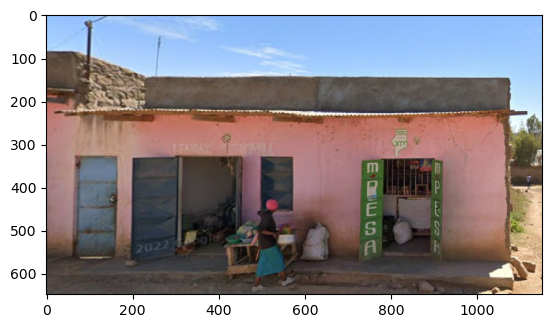

In [23]:
plt.imshow(build_image_list[300])
plt.show()

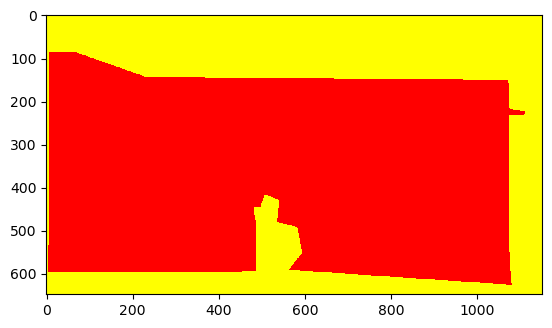

In [24]:
plt.imshow(build_mask_list[300], cmap=cmap, norm=norm)
plt.show()

In [25]:
# Now let's do this for the roads
road_image_list, road_mask_list = extract_image_mask(img_ann_road_list, road_lab)

 Failed 0 times in creatig masks out of 638 annotations


In [26]:
print(f"No of road images with mask: {len(road_image_list)}")

No of road images with mask: 588


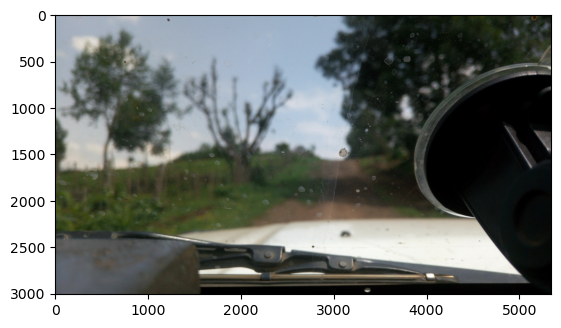

In [27]:
plt.imshow(road_image_list[580])
plt.show()

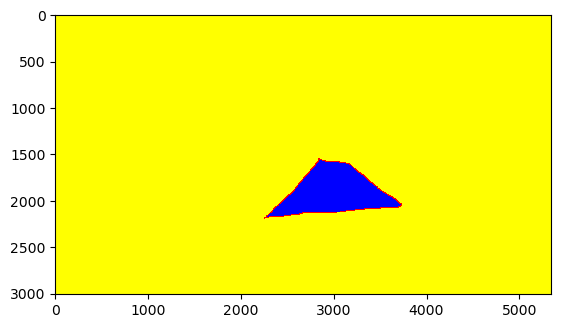

In [28]:
plt.imshow(road_mask_list[580], cmap=cmap, norm=norm)
plt.show()

In [29]:
road_mask_list[580].shape

(3008, 5344)

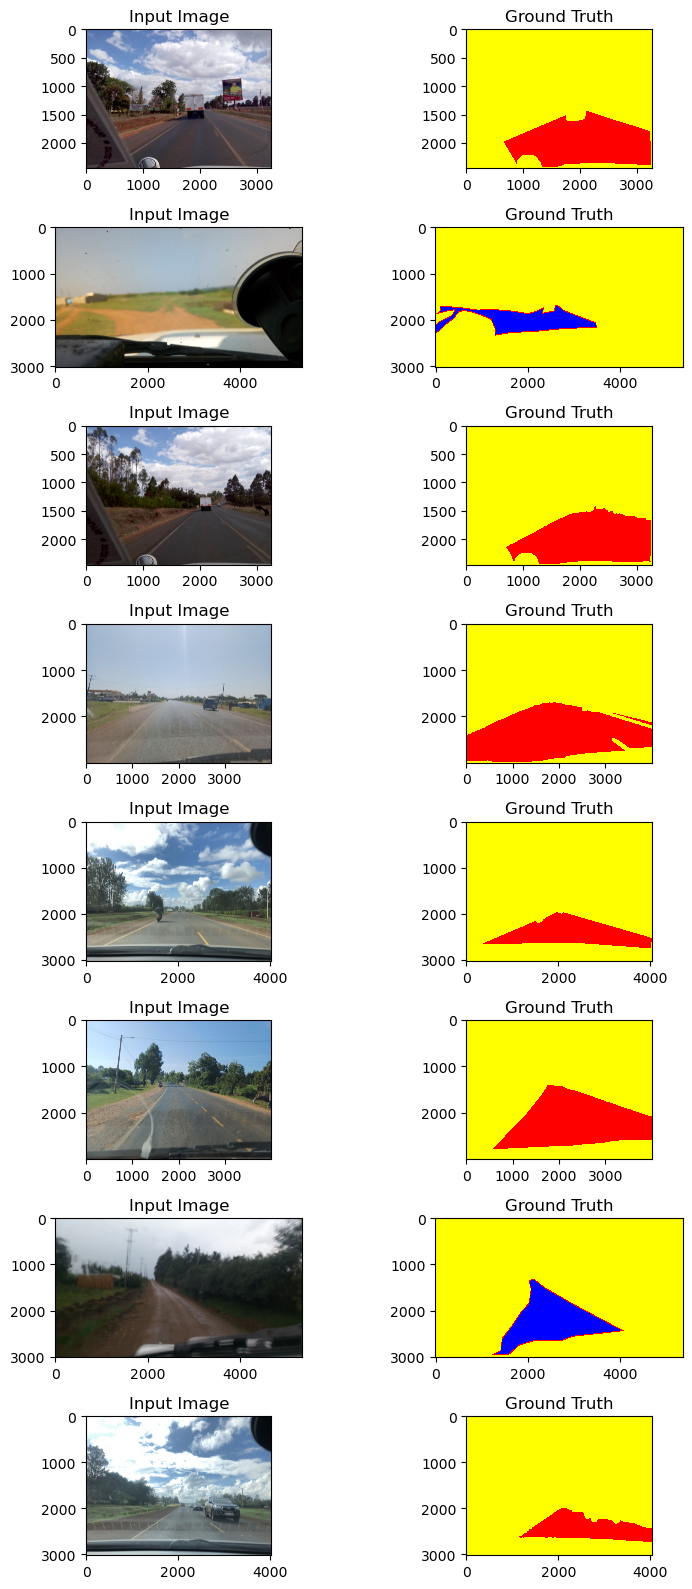

In [30]:
## visualize some of the created images and masks
fig, axs = plt.subplots(8, 2, figsize=(8, 16))
for i, ind in enumerate(range(8, 16)):
    axs[i][0].imshow(road_image_list[i], cmap=cmap, norm=norm)
    axs[i][0].set_title("Input Image")
    axs[i][1].imshow(road_mask_list[i], cmap=cmap, norm=norm)
    axs[i][1].set_title("Ground Truth")

plt.tight_layout()
plt.show()

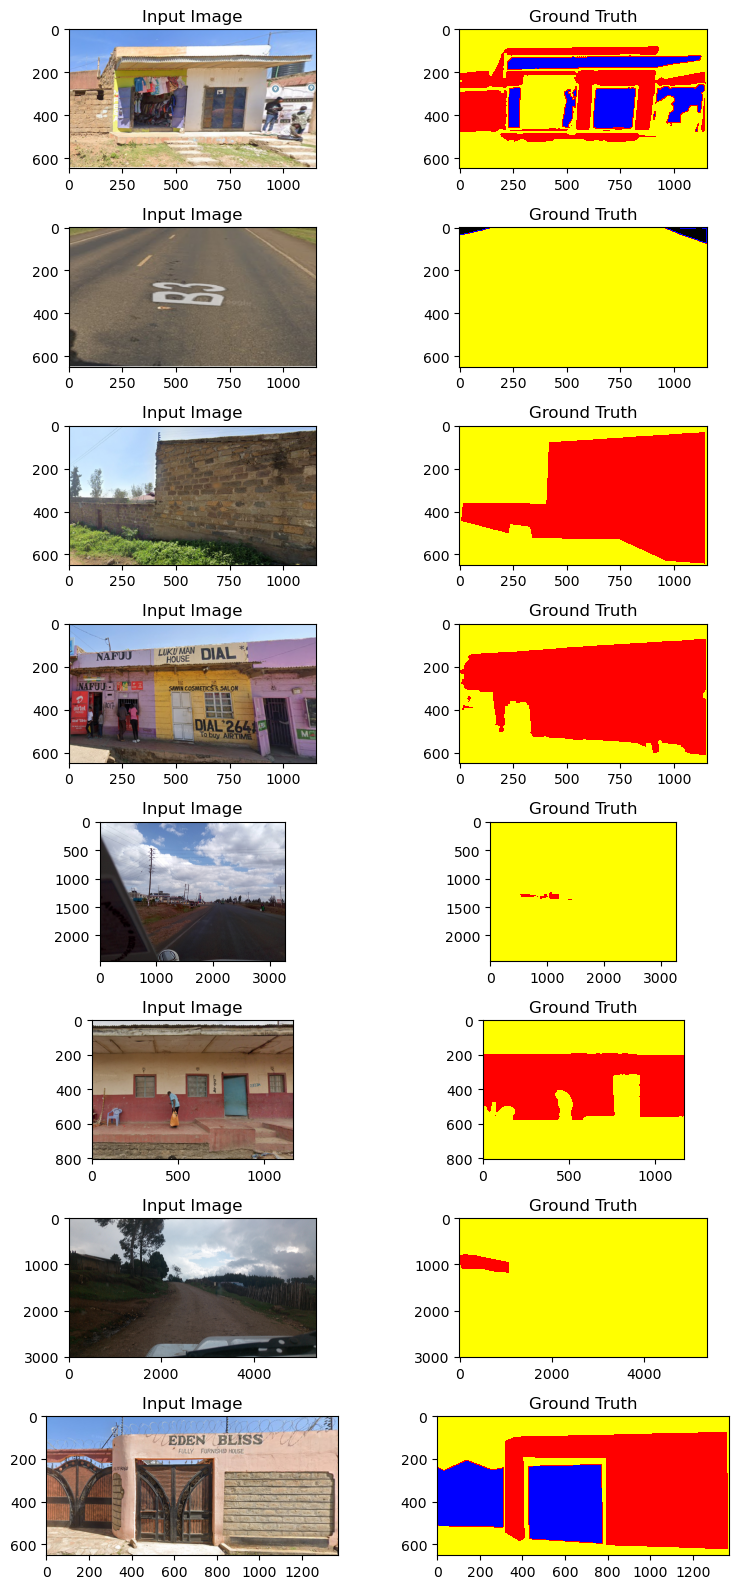

In [31]:
## visualize some of the created images and masks
fig, axs = plt.subplots(8, 2, figsize=(8, 16))
for i, ind in enumerate(range(8, 16)):
    axs[i][0].imshow(build_image_list[ind], cmap=cmap, norm=norm)
    axs[i][0].set_title("Input Image")
    axs[i][1].imshow(build_mask_list[ind], cmap=cmap, norm=norm)
    axs[i][1].set_title("Ground Truth")

plt.tight_layout()
plt.show()

In [32]:
# Let's read the image file into a numpy array
#dimensions of the resized image
width, height = [512, 512]

def preprocess_data(img_list, mask_list):
    """
    Save the numpy array with loaded images and masks
    args:
    img_list: List containing image arrays
    mask_list : List containing 
    """
    samp = len(img_list)
    array_img = np.zeros((samp, height, width, 3), dtype = np.float32) # Each image with width, height and 3 RGB channels
    array_mask = np.zeros((samp, height, width), dtype=np.uint8)
    
    for i in range(samp):    
        
        # Load the image and mask
        img = img_list[i]
        mask = mask_list[i]
        
        img_resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA) # resize the images
        array_img[i,:,:,:] = img_resized/255 # Normalize the pixel values

        mask_resized = cv2.resize(mask, (width, height), interpolation=cv2.INTER_AREA) # resize the images
        array_mask[i,:,:] = mask_resized

    return (array_img, array_mask)     

In [33]:
# Getting images and mask for roads
road_img, road_mask = preprocess_data(road_image_list, road_mask_list)

In [79]:
## saving them into a numpy array
np.savez("/Users/savin/Omdena-Projects/HOTOSM/data/Mask/road_mask", image=road_img, mask=road_mask)

In [35]:
# Getting images and masks for building
build_img, build_mask = preprocess_data(build_image_list, build_mask_list)

In [81]:
## saving them into a numpy array
np.savez("/Users/savin/Omdena-Projects/HOTOSM/data/Mask/building_mask", image=build_img, mask=build_mask)

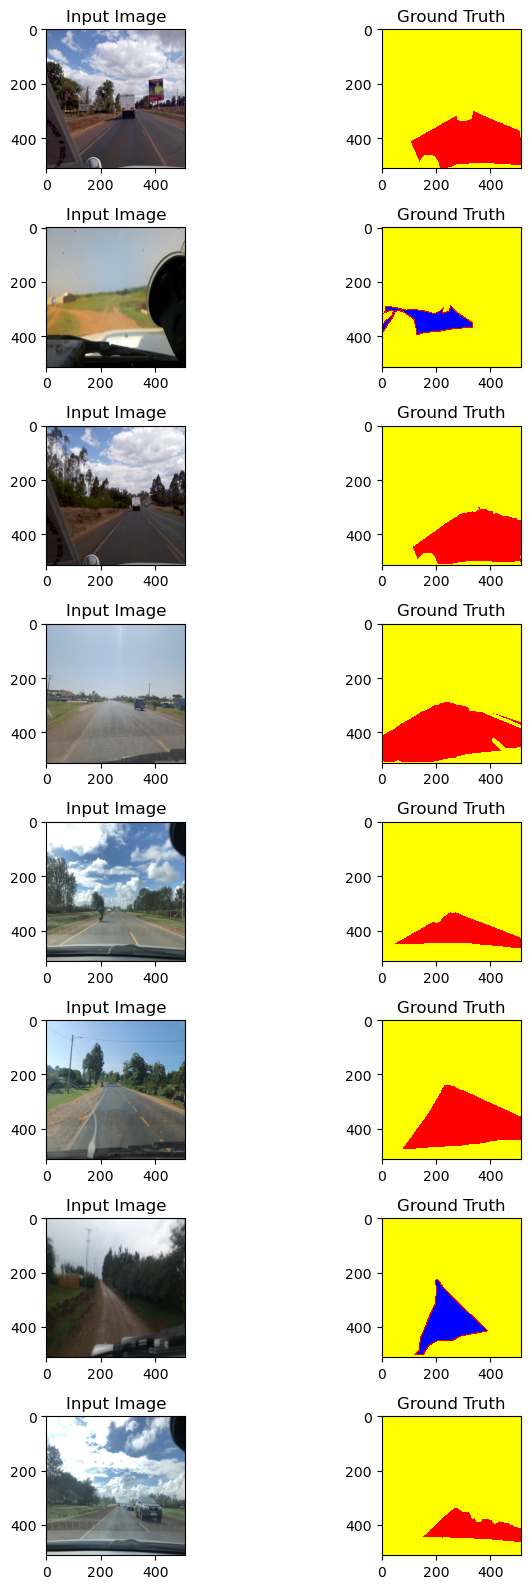

In [37]:
## visualize some of the created images and masks
fig, axs = plt.subplots(8, 2, figsize=(8, 16))
for i in range(8):
    axs[i][0].imshow(road_img[i], cmap=cmap, norm=norm)
    axs[i][0].set_title("Input Image")
    axs[i][1].imshow(road_mask[i], cmap=cmap, norm=norm)
    axs[i][1].set_title("Ground Truth")

plt.tight_layout()
plt.show()

In [38]:
print(np.unique(road_mask[0]))

[0 1]


In [39]:
print(np.unique(build_mask[10]))

[0 1]


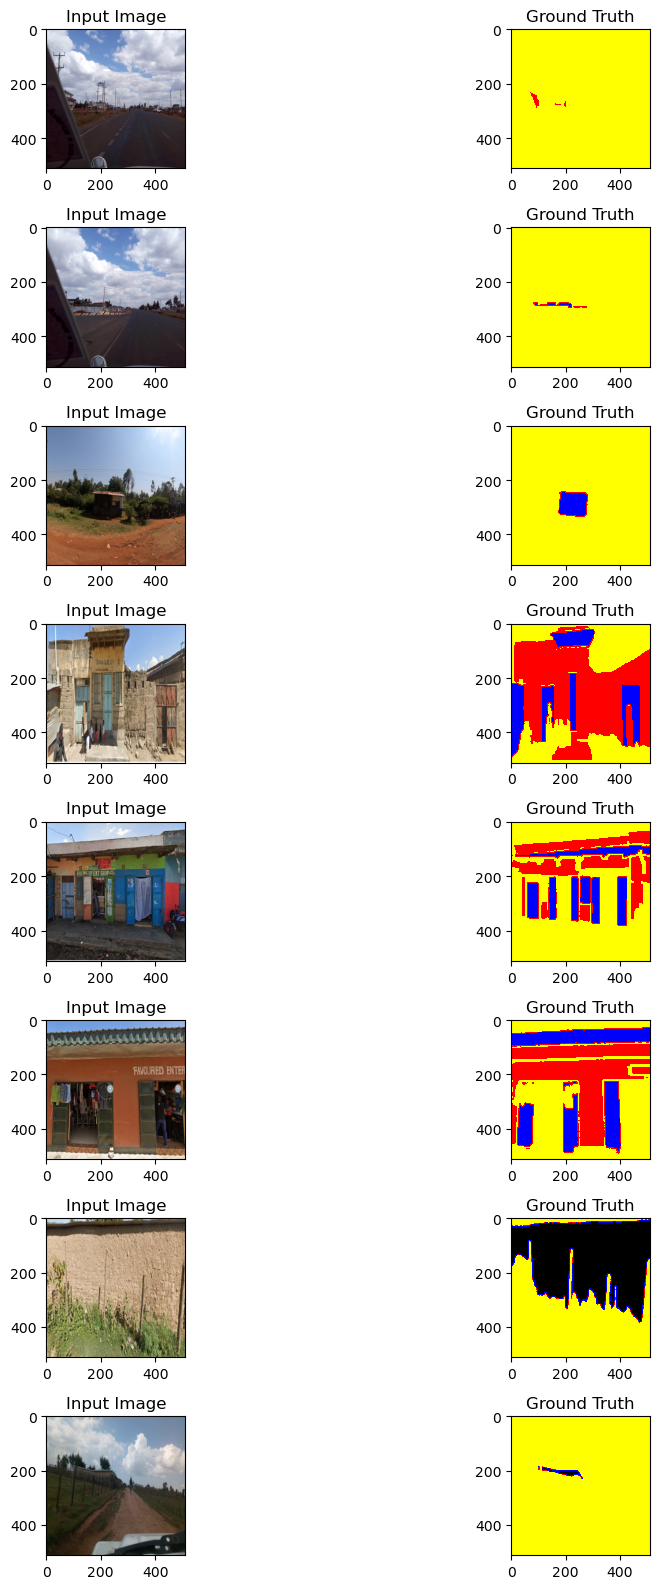

In [40]:
## visualize some of the created images and masks
fig, axs = plt.subplots(8, 2, figsize=(12, 16))
for i, ind in enumerate(range(16,24)):
    axs[i][0].imshow(build_img[ind], cmap=cmap, norm=norm)
    axs[i][0].set_title("Input Image")
    axs[i][1].imshow(build_mask[ind], cmap=cmap, norm=norm)
    axs[i][1].set_title("Ground Truth")

plt.tight_layout()
plt.show()